# Working with output from general circulation models

In this lecture we will discuss some basic aspects and techniques to work with output of general circulation models.

## What is a general circulation model?

A general circulation model (GCM) is a computer model which simulates the circulation a fluid (e.g. the ocean or atmosphere). The model is based on a set of partial differential equations, which describe the motion of a fluid in 3D space, and integrates these forward in time.  Most fundamentally these models use a discrete representation of the [Navier-Stokes Equations](https://en.wikipedia.org/wiki/Navier%E2%80%93Stokes_equations) but can include more equations to represent e.g. the thermodynamics, chemistry or biology of the coupled earth system.

## The globe divided in boxes
Since there is not analytical solution to the full Navier-Stokes equation, modern GCMs solve them using numerical method. They use a discretized version of the equations, which approximates them within a finite volume, or grid-cell. Each GCM splits the ocean and/or atmoshpere into many cells both in the horizontal and vertical.

![gcm-schematic](https://www.ipcc-data.org/img/3d_gcm_structure.jpg)
> Source: www.ipcc-data.org

It is numerically favorable to shift (or 'stagger') the grid points where the velocity is calculated by the model with regard to the grid point where tracer values (temperature, salinity etc.) are calculated. There are several different ways to shift these points, commonly referred to as [Arakawa grids](https://en.wikipedia.org/wiki/Arakawa_grids). Most modern ocean models use a C-Grid, thus this lecture will focus on this particular grid configuration.
In the C-grid, the zonal velocity $u$ is located on the right side (or east face) of the tracer location and the meridional velocity $v$ is located on the upper side (or north face). Similarly the vertical velocity $w$ is shifted with depth but horizontally (when looking at it from straight above) it is on the tracer location.

![c-grid](https://xgcm.readthedocs.io/en/latest/_images/grid2d_hv.svg)
> Source: xgcm.readthedocs.io

## Consequences
Discretizing the equations has consequences: 

- In order to get a realistic representation of the global circulation, the size of grid cells needs to be chosen so that all relevant processes are resolved (often requires too much computing power for global models) or processes that are to small to be explicitly resolved (e.g. [ocean eddies]() or vertical mixing [](), need to be carefully parameterized since they influence the large scale circulation (example?).

- The size of the boxes should not vary too much and cannot be infinitely small, leading to unituitive layout of grid cells particularly around the north pole.

> We will learn how to `regrid` model fields to easier resolutions later in the lesson

- 'squished' boxes (not perfectly rectangular) require careful tracking of the cell geometry (or grid metrics) to calculate operators like e.g. divergence.

> We will learn how to use [xgcm]() in order to deal with computations on the raw model grid.




## Calculus on finite boxes
Sublte differences exists between the numerical methods used in the code of different models, but for this lecture we consider the [Finite Volume Method](https://en.wikipedia.org/wiki/Finite_volume_method), which is used in many modern ocean models. Essentially, this means that all equations with a divergence term are evaluated as fluxes at the surfaces of each finite volume or grid-cell.


## grid size and computation?

## Grid metrics (cells are not actual boxes)

In [1]:
# Video to show difference in resolution
# https://vimeo.com/259423826
from IPython.display import HTML
HTML('<iframe src="https://player.vimeo.com/video/259423826" width="640" height="360" frameborder="0" allow="autoplay; fullscreen" allowfullscreen></iframe>')

/srv/conda/envs/notebook/lib/python3.7/site-packages/IPython/core/display.py:694: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [2]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from xgcm import Grid
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina'

In [3]:
import intake
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds_model = cat["cesm_mom6_example"].to_dask()

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:431: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  self.use_cftime)


In [4]:
ds_model

<xarray.Dataset>
Dimensions:       (lath: 458, latq: 458, lonh: 540, lonq: 540, nv: 2, scalar_axis: 1, time: 24, xh: 540, xq: 540, yh: 458, yq: 458, z_i: 35, z_l: 34)
Coordinates:
    geolat        (yh, xh) float64 dask.array<shape=(458, 540), chunksize=(458, 540)>
    geolatb       (yq, xq) float64 dask.array<shape=(458, 540), chunksize=(458, 540)>
    geolon        (yh, xh) float64 dask.array<shape=(458, 540), chunksize=(458, 540)>
    geolonb       (yq, xq) float64 dask.array<shape=(458, 540), chunksize=(458, 540)>
  * lath          (lath) float64 -79.2 -79.08 -78.95 ... 87.64 87.71 87.74
  * latq          (latq) float64 -79.14 -79.01 -78.89 ... 87.68 87.73 87.74
  * lonh          (lonh) float64 -286.7 -286.0 -285.3 ... 71.33 72.0 72.67
  * lonq          (lonq) float64 -286.3 -285.7 -285.0 ... 71.67 72.33 73.0
  * nv            (nv) float64 1.0 2.0
  * scalar_axis   (scalar_axis) float64 0.0
  * time          (time) object 0001-01-16 12:00:00 ... 0002-12-16 12:00:00
  * xh          

In [5]:
sst_model = ds_model.SST
sst_model

<xarray.DataArray 'SST' (time: 24, yh: 458, xh: 540)>
dask.array<shape=(24, 458, 540), dtype=float64, chunksize=(1, 458, 540)>
Coordinates:
    geolat   (yh, xh) float64 dask.array<shape=(458, 540), chunksize=(458, 540)>
    geolon   (yh, xh) float64 dask.array<shape=(458, 540), chunksize=(458, 540)>
  * time     (time) object 0001-01-16 12:00:00 ... 0002-12-16 12:00:00
  * xh       (xh) float64 -286.7 -286.0 -285.3 -284.7 ... 70.67 71.33 72.0 72.67
  * yh       (yh) float64 -79.2 -79.08 -78.95 -78.82 ... 87.55 87.64 87.71 87.74
Attributes:
    cell_measures:  area: area_t
    cell_methods:   area:mean yh:mean xh:mean time: mean
    long_name:      Sea Surface Temperature
    time_avg_info:  average_T1,average_T2,average_DT
    units:          degC

In [6]:
# ds_model[['u', 'v', 'temp']].temp.isel(z_l=0).mean('time').plot()

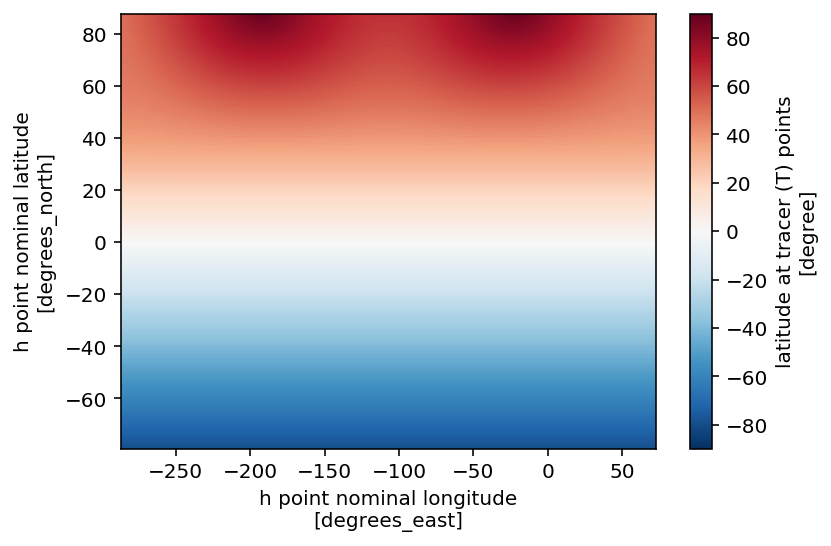

In [7]:
ds_model.geolat.plot()

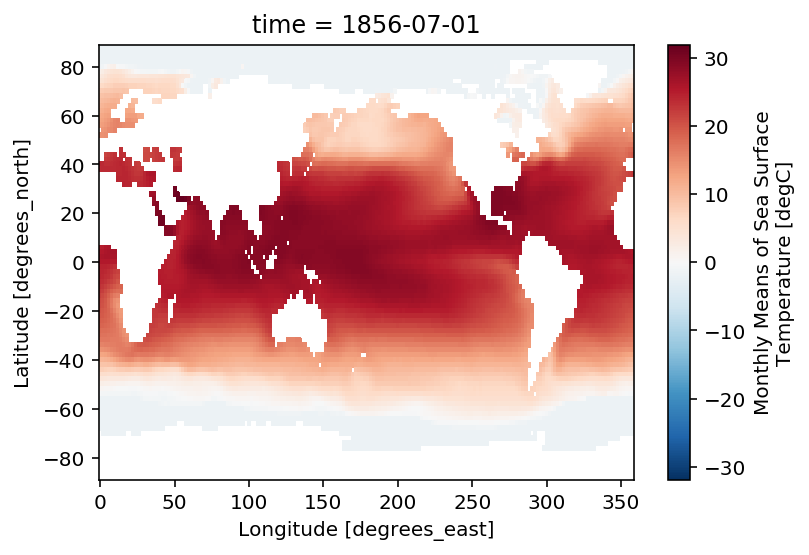

In [8]:
import xarray as xr
# xr.set_options(display_style='html') # !!! need to update xarray for this?
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ds_obs = xr.open_dataset(url).chunk({'time': 12})
sst = ds_obs.sst#.mean('time').plot()
sst.isel(time=30).plot()

A very common analysis step for model analysis is comparing model fields with observations - so called model validation.
So how would we approach this with our two datasets?

Lets first create two time mean dataarrays for the model and observed SST
(The observational dataset will take a while to process, so we will have some time for questions).

In [9]:
sst_model = ds_model.SST.mean('time').load()
sst_obs = ds_obs.sst.mean('time').load()

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


We can now plot both fields next to each other. 

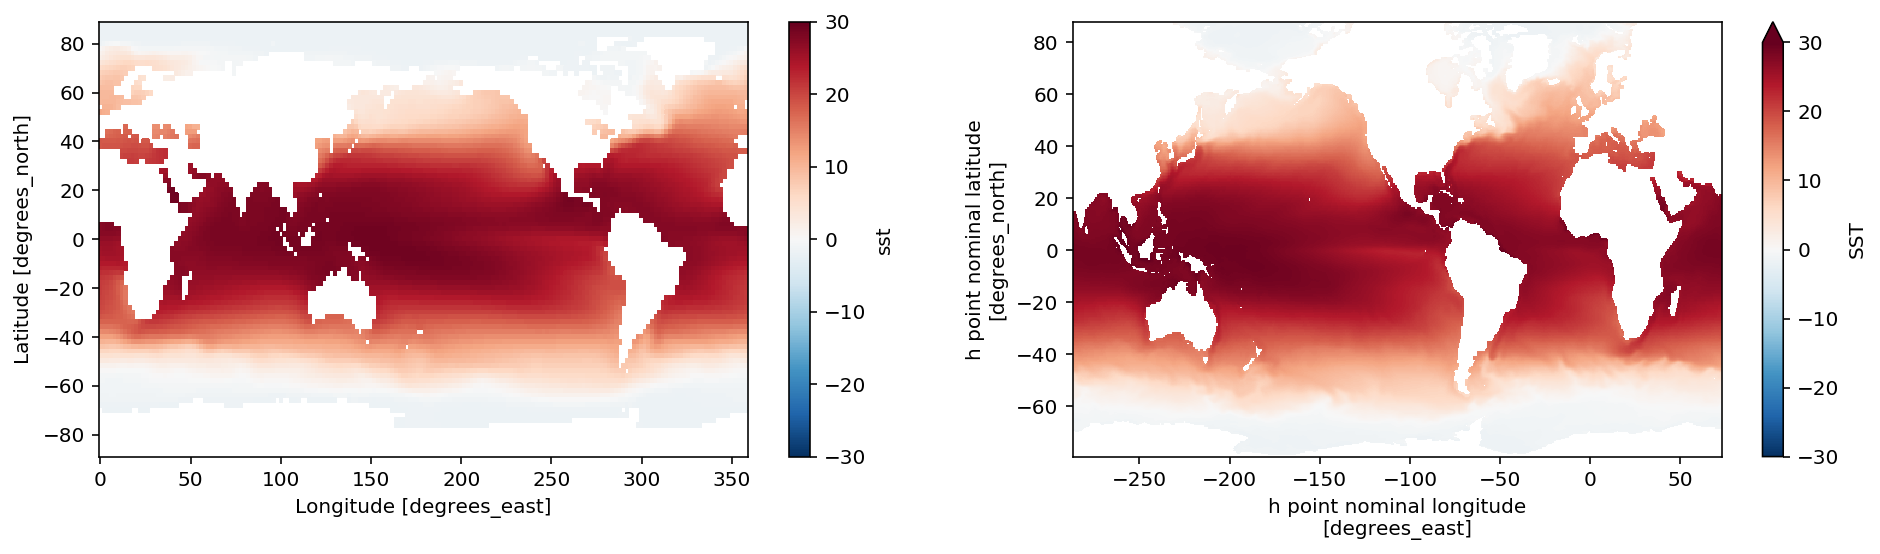

In [10]:
plt.figure(figsize=[16,4])
plt.subplot(1,2,1) # !!! is this taught before?
sst_obs.plot(vmax=30) # make sure to have the same colorlimit

plt.subplot(1,2,2)
sst_model.plot(vmax=30)

This is nice but since temperature differs so over a wide range over the globe, it is hard to distinguish the differences. Naturally we would want to plot the difference between both datasets. 

There is however a major problem: Both datasets are on a different grid. 


The observational dataset is on a regular latitude longitude grid (both are 1 dimensional coordinates)

In [11]:
sst_obs

<xarray.DataArray 'sst' (lat: 89, lon: 180)>
array([[-1.799823, -1.799826, -1.799835, ..., -1.799873, -1.799845, -1.799828],
       [-1.799839, -1.799815, -1.7998  , ..., -1.799955, -1.799901, -1.799868],
       [-1.799995, -1.799941, -1.799906, ..., -1.799967, -1.799977, -1.799989],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0



Whereas the model data is on a more complex curvilinear grid, due to the fact that a regular lat lon grid would require infintely small cells at the north pole.

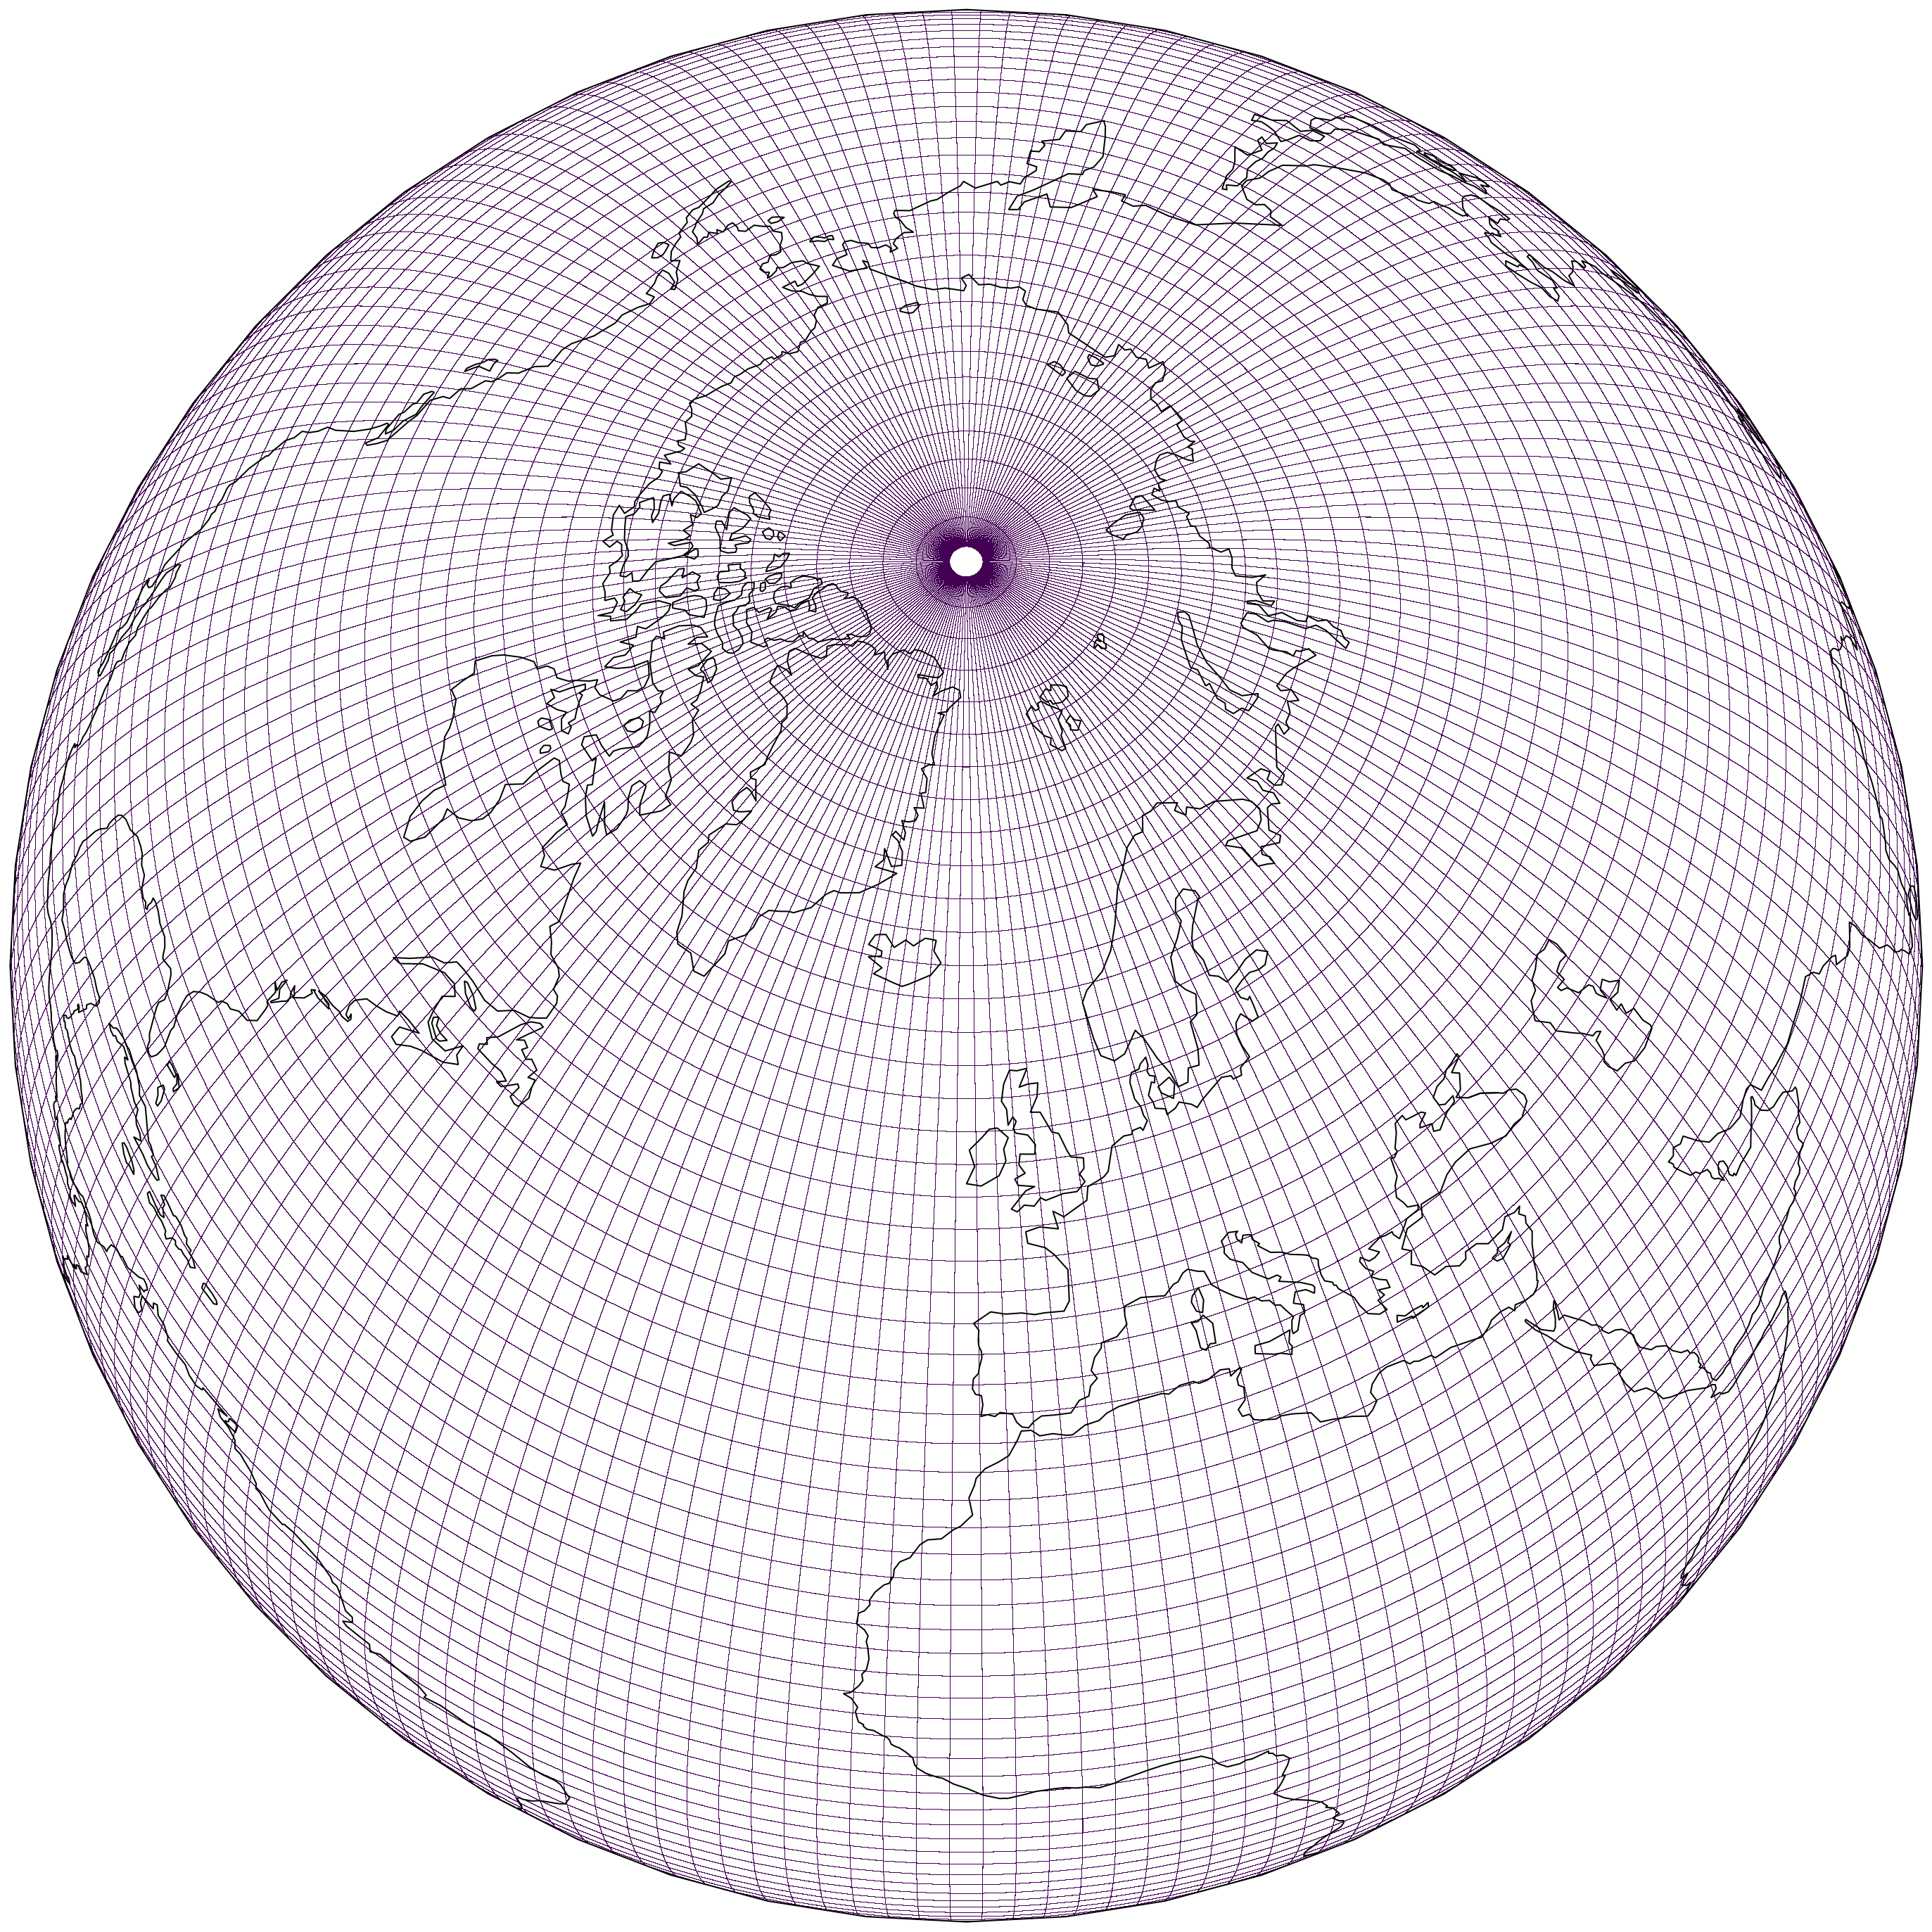

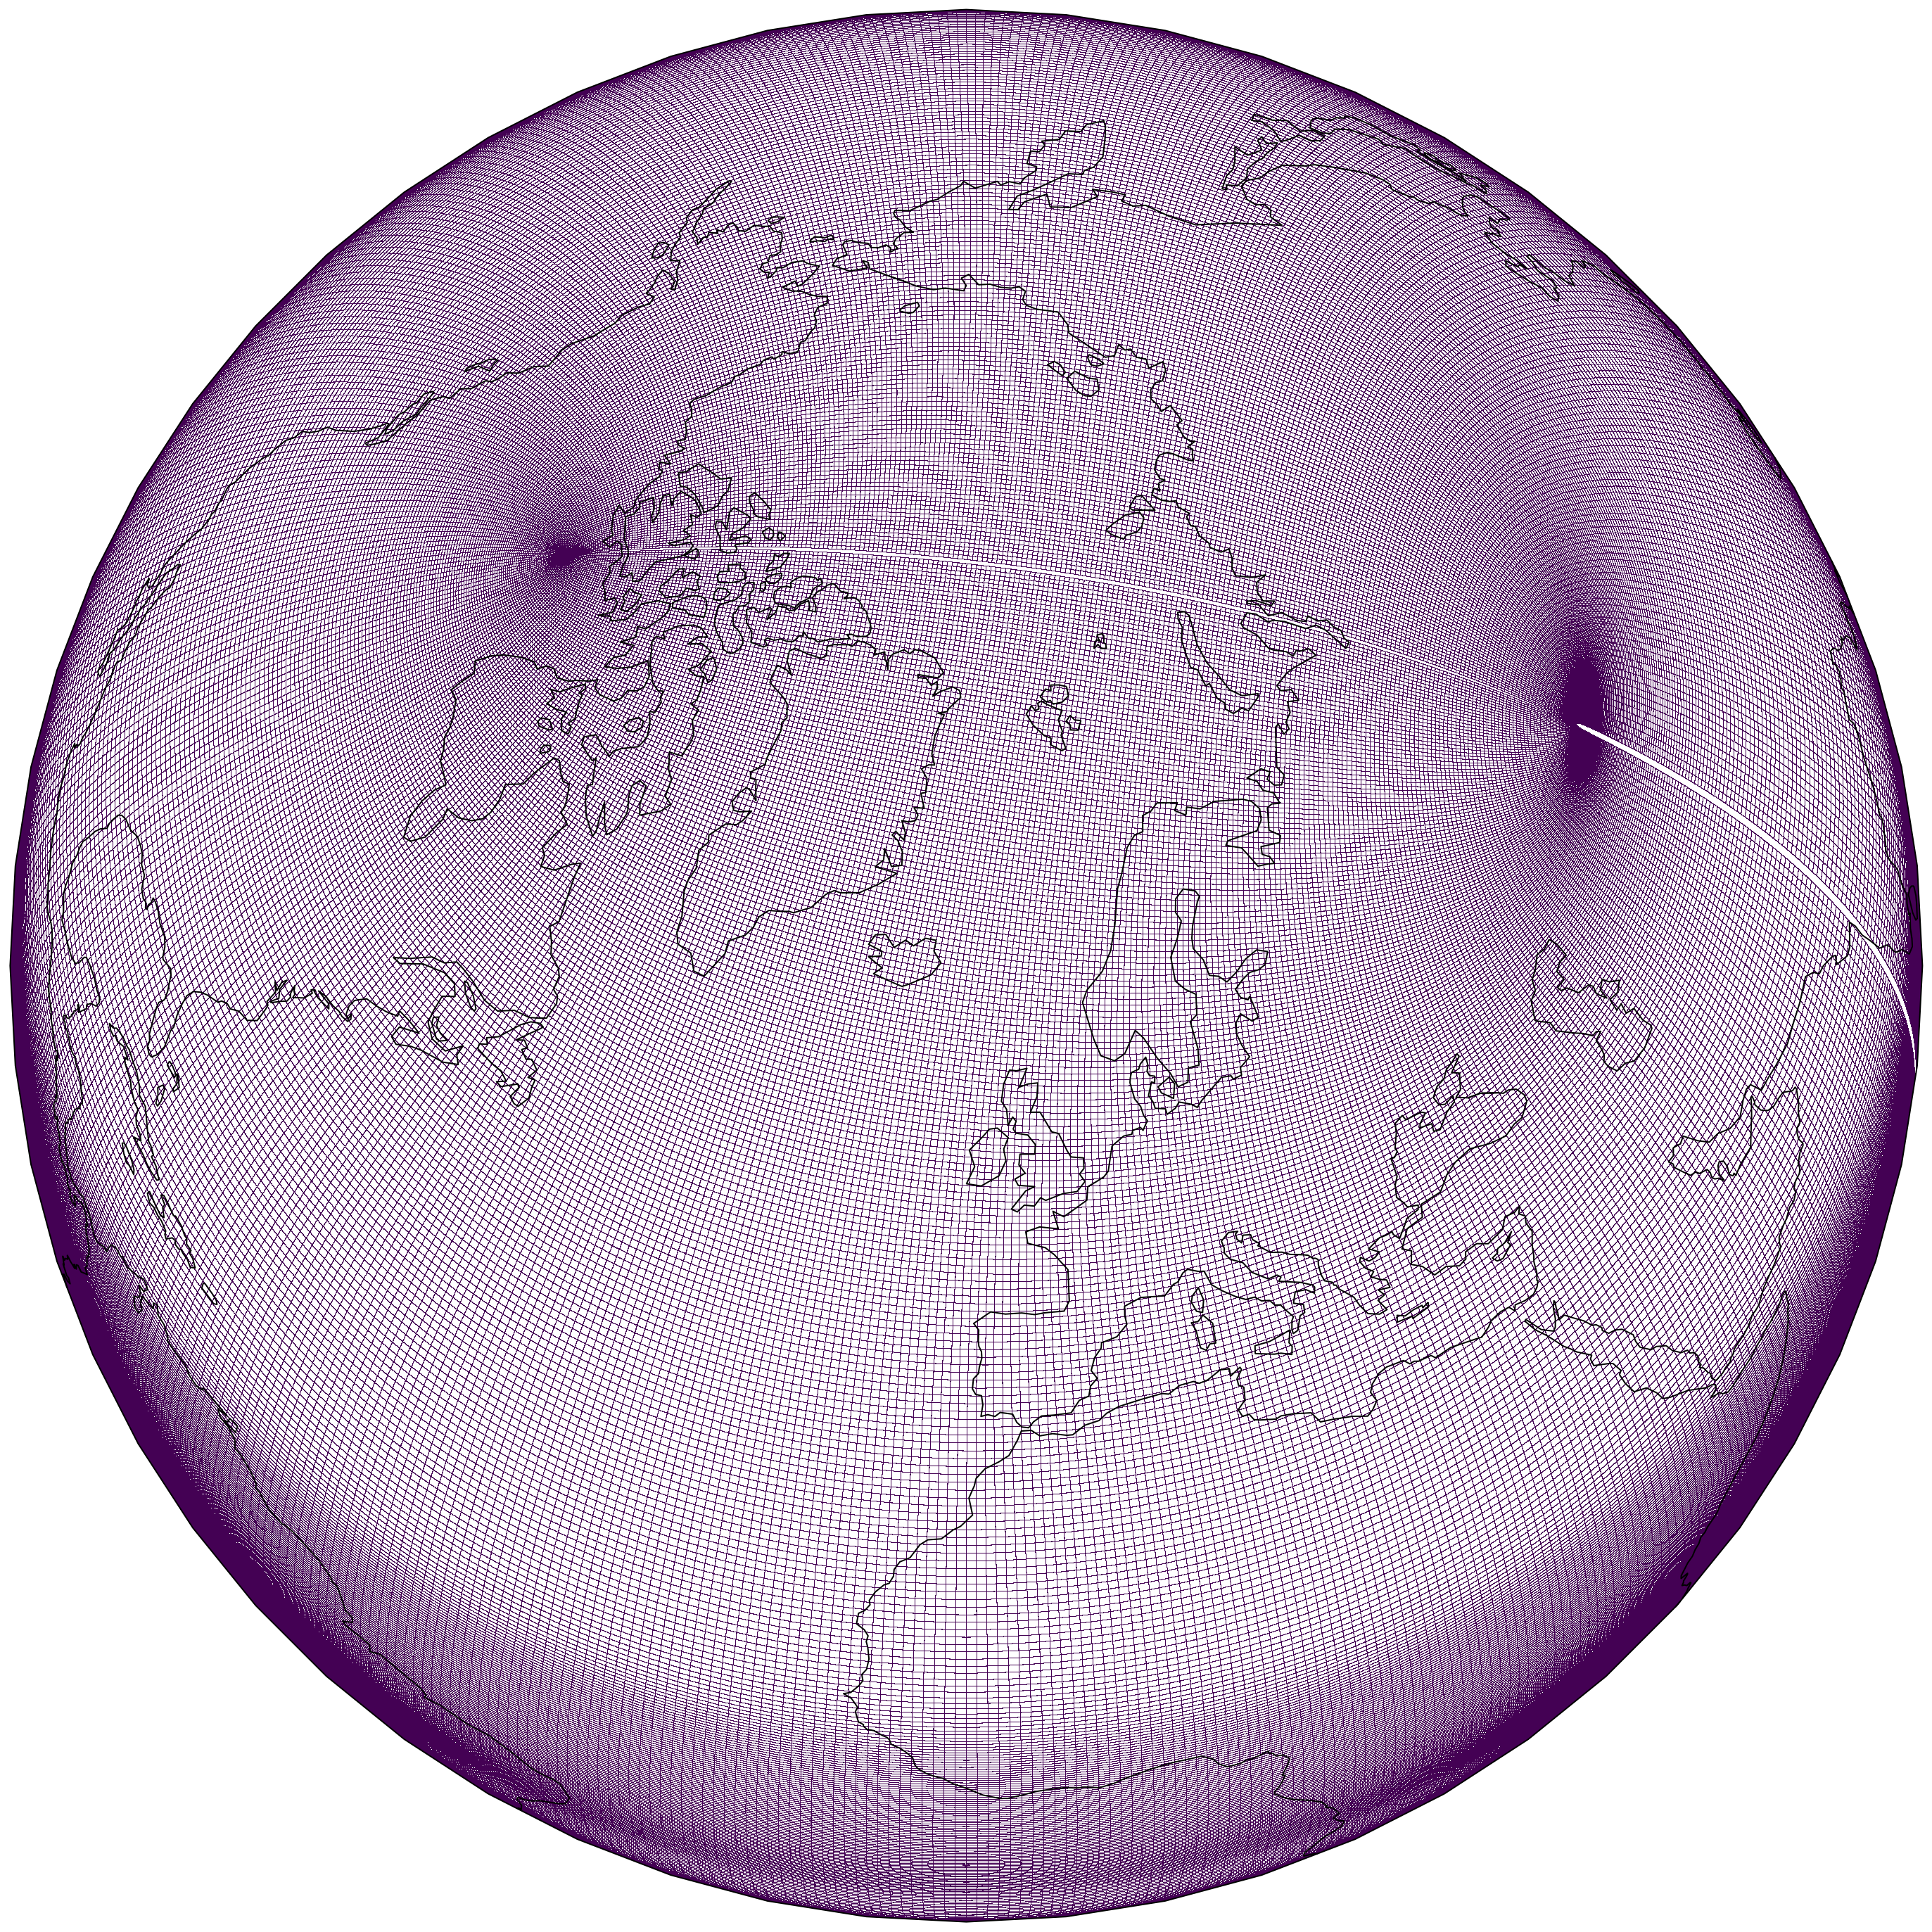

In [12]:
# visualize the model and obs grids
plt.figure(figsize=[25,25])
import cartopy.crs as ccrs
ax = plt.axes(projection=ccrs.Orthographic(-10, 65))
xr.ones_like(sst_obs).plot.pcolormesh(ax=ax,facecolors='none',edgecolors=['k'], linewidth=0.01, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()

# visualize the model and obs grids
plt.figure(figsize=[25,25])
import cartopy.crs as ccrs
ax = plt.axes(projection=ccrs.Orthographic(-10, 65))
xr.ones_like(sst_model).plot.pcolormesh(ax=ax, x='geolon', y='geolat',facecolors='none',edgecolors=['k'], linewidth=0.01, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()

<xarray.DataArray 'SST' (yh: 458, xh: 540)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    geolat   (yh, xh) float64 -79.2 -79.2 -79.2 -79.2 ... 50.27 50.11 49.99
    geolon   (yh, xh) float64 -286.7 -286.0 -285.3 -284.7 ... 72.97 72.98 73.0
  * xh       (xh) float64 -286.7 -286.0 -285.3 -284.7 ... 70.67 71.33 72.0 72.67
  * yh       (yh) float64 -79.2 -79.08 -78.95 -78.82 ... 87.55 87.64 87.71 87.74


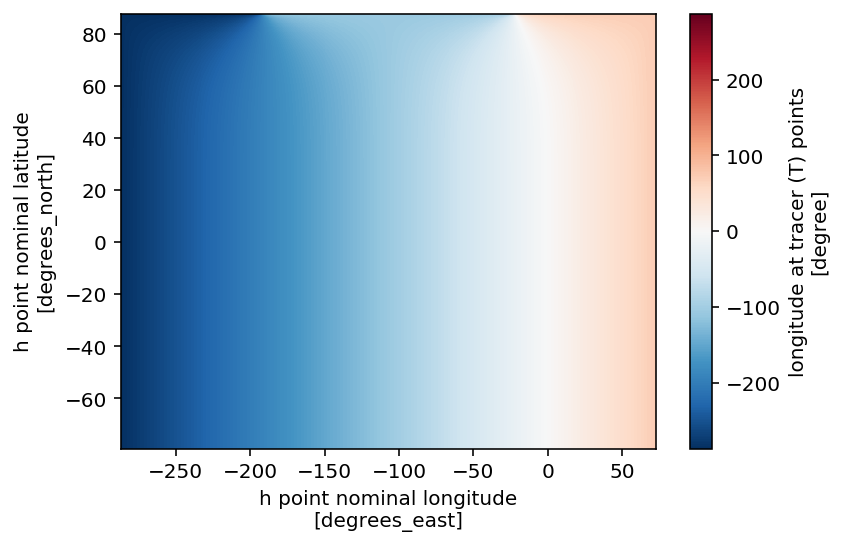

In [13]:
print(sst_model)
sst_model.geolon.plot()

So we need to convert one or both of the grids in order to be able to difference the datasets.

For this step we will use [xesmf](https://xesmf.readthedocs.io/en/latest/) a very powerful geospatial regridding tool.

In [14]:
import xesmf as xe

to regrid a dataarray with xesmf you need to execute the following steps:

1. Create a target grid dataset (this can also be an existing dataset)
    1.1 Rename the dataset appropriately. xesmf expects longitude and latitude to be labelled as `lon` and `lat`
2. Create a `regridder` object (using the target grid and the source dataset - e.g. the dataset that should be regridded)
    2.1 Clean existing files that the regridder might have written out (this is only needed if the regridder has been previously applied)
3. Apply the `regridder`

As an example we will regrid both models onto a common 0.5 deg by 0.5 deg resolution. This is a similar resolution as the model has, but much finer than the observations.

In [32]:
ds_target = xe.util.grid_global(1, 0.5)
regridder = xe.Regridder(sst_obs, ds_target, 'bilinear', periodic=True) #since this is global we need to pass periodic
regridder.clean_weight_file()
regridder

Create weight file: bilinear_89x180_360x360_peri.nc
Remove file bilinear_89x180_360x360_peri.nc


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_89x180_360x360_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (89, 180) 
Output grid shape:          (360, 360) 
Output grid dimension name: ('y', 'x') 
Periodic in longitude?      True

In [33]:
sst_obs_regridded = regridder(sst_obs)
# sst_obs_regridded

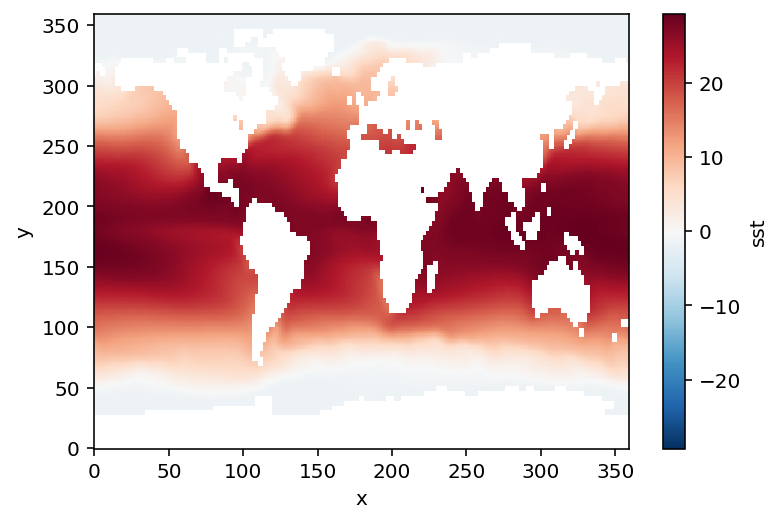

In [34]:
sst_obs_regridded.plot()

You can see that the dataset now has much more point then before, e.g. the resoltion was increased. However, the data was only bilinearly interpolated, so there is no additional information at smaller scales. Lets repeat that step for the model data:

In [35]:
sst_model

<xarray.DataArray 'SST' (yh: 458, xh: 540)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    geolat   (yh, xh) float64 -79.2 -79.2 -79.2 -79.2 ... 50.27 50.11 49.99
    geolon   (yh, xh) float64 -286.7 -286.0 -285.3 -284.7 ... 72.97 72.98 73.0
  * xh       (xh) float64 -286.7 -286.0 -285.3 -284.7 ... 70.67 71.33 72.0 72.67
  * yh       (yh) float64 -79.2 -79.08 -78.95 -78.82 ... 87.55 87.64 87.71 87.74

In [36]:
regridder = xe.Regridder(sst_model.rename({'geolon':'lon', 'geolat':'lat'}), ds_target, 'bilinear', periodic=True) #Here we do need to rename the coordinates
regridder.clean_weight_file()
sst_model_regridded = regridder(sst_model)

Create weight file: bilinear_458x540_360x360_peri.nc
Remove file bilinear_458x540_360x360_peri.nc


In [37]:
sst_model_regridded

<xarray.DataArray 'SST' (y: 360, x: 360)>
array([[      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       ...,
       [-1.412961, -1.4132  , -1.413441, ..., -1.41226 , -1.412491, -1.412725],
       [-1.41461 , -1.414773, -1.414873, ..., -1.414115, -1.414278, -1.414443],
       [-1.396646, -1.396624, -1.396599, ..., -1.396689, -1.396678, -1.396664]])
Coordinates:
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    lat      (y, x) float64 -89.75 -89.75 -89.75 -89.75 ... 89.75 89.75 89.75
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  bilinear

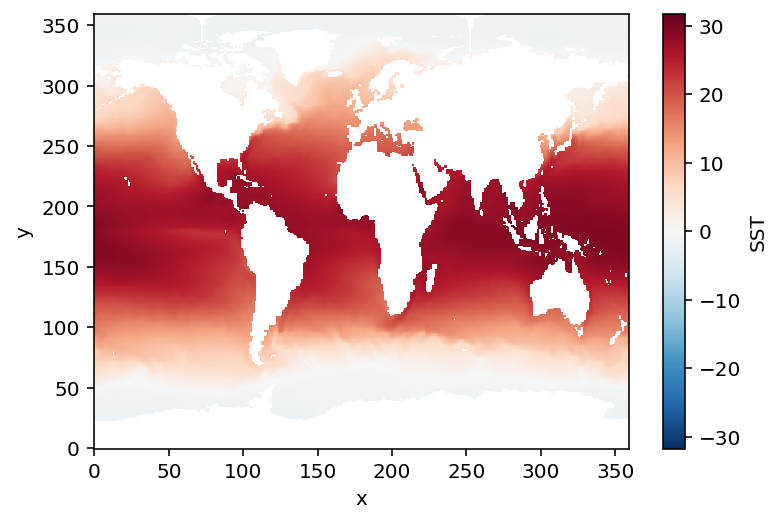

In [38]:
sst_model_regridded.plot()

Note that both datasets now have the exact same coordinate values, both of which are now 2 dimensional arrays. Now we can easily subtract them.

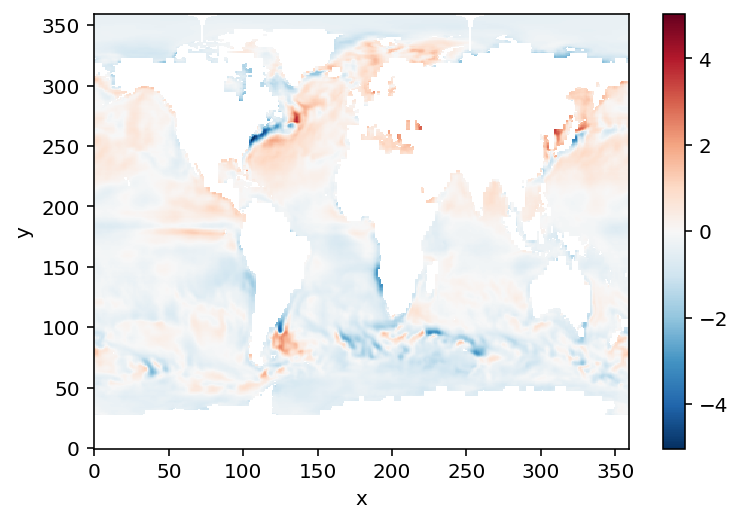

In [40]:
diff = sst_obs_regridded - sst_model_regridded
diff.plot()

## try again with conservative regridding


In [43]:
ds_new = ds_model.isel(xh=slice(1,None), yh=slice(1,None)).rename({'geolon':'lon', 'geolat':'lat', 'geolonb':'lon_b', 'geolatb':'lat_b'})
ds_new

<xarray.Dataset>
Dimensions:       (lath: 458, latq: 458, lonh: 540, lonq: 540, nv: 2, scalar_axis: 1, time: 24, xh: 539, xq: 540, yh: 457, yq: 458, z_i: 35, z_l: 34)
Coordinates:
    lat           (yh, xh) float64 -79.08 -79.08 -79.08 ... 50.27 50.11 49.99
    lat_b         (yq, xq) float64 dask.array<shape=(458, 540), chunksize=(458, 540)>
    lon           (yh, xh) float64 -286.0 -285.3 -284.7 ... 72.97 72.98 73.0
    lon_b         (yq, xq) float64 dask.array<shape=(458, 540), chunksize=(458, 540)>
  * lath          (lath) float64 -79.2 -79.08 -78.95 ... 87.64 87.71 87.74
  * latq          (latq) float64 -79.14 -79.01 -78.89 ... 87.68 87.73 87.74
  * lonh          (lonh) float64 -286.7 -286.0 -285.3 ... 71.33 72.0 72.67
  * lonq          (lonq) float64 -286.3 -285.7 -285.0 ... 71.67 72.33 73.0
  * nv            (nv) float64 1.0 2.0
  * scalar_axis   (scalar_axis) float64 0.0
  * time          (time) object 0001-01-16 12:00:00 ... 0002-12-16 12:00:00
  * xh            (xh) float64 -2

In [54]:
ds_target = xe.util.grid_global(5, 5)

In [55]:
rg = xe.Regridder(ds_new, ds_target, 'conservative')
rg.clean_weight_file()
ds_conservative = rg(ds_new.SST)
ds_conservative

/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/backend.py:36: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not F_CONTIGUOUS. "


Create weight file: conservative_457x539_36x72.nc
Remove file conservative_457x539_36x72.nc


<xarray.DataArray 'SST' (time: 24, y: 36, x: 72)>
dask.array<shape=(24, 36, 72), dtype=float64, chunksize=(1, 36, 72)>
Coordinates:
  * time     (time) object 0001-01-16 12:00:00 ... 0002-12-16 12:00:00
    lon      (y, x) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
    lat      (y, x) float64 -87.5 -87.5 -87.5 -87.5 ... 87.5 87.5 87.5 87.5
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  conservative

In [56]:
rg = xe.Regridder(ds_new, ds_target, 'bilinear')
rg.clean_weight_file()
ds_linear = rg(ds_new.SST)
ds_linear

/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/backend.py:36: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not F_CONTIGUOUS. "


Create weight file: bilinear_457x539_36x72.nc
Remove file bilinear_457x539_36x72.nc


<xarray.DataArray 'SST' (time: 24, y: 36, x: 72)>
dask.array<shape=(24, 36, 72), dtype=float64, chunksize=(1, 36, 72)>
Coordinates:
  * time     (time) object 0001-01-16 12:00:00 ... 0002-12-16 12:00:00
    lon      (y, x) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
    lat      (y, x) float64 -87.5 -87.5 -87.5 -87.5 ... 87.5 87.5 87.5 87.5
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  bilinear

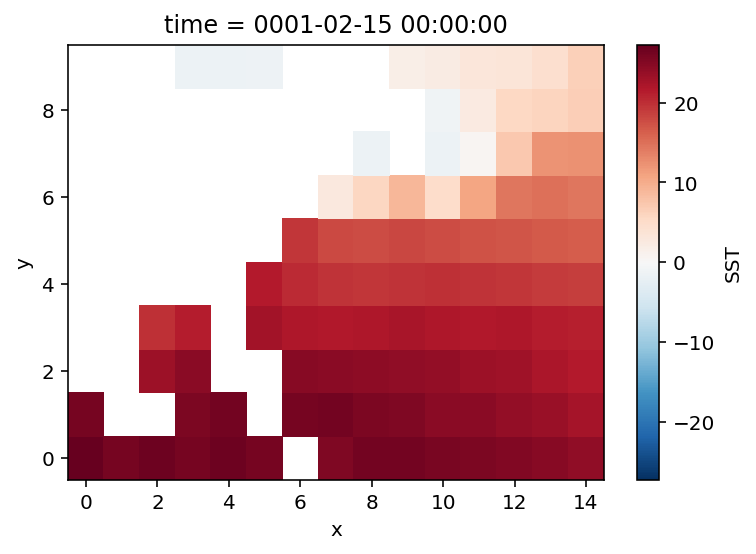

In [62]:
ds_linear.sel(x=slice(15,30), y=slice(20,30)).isel(time=1).plot()#

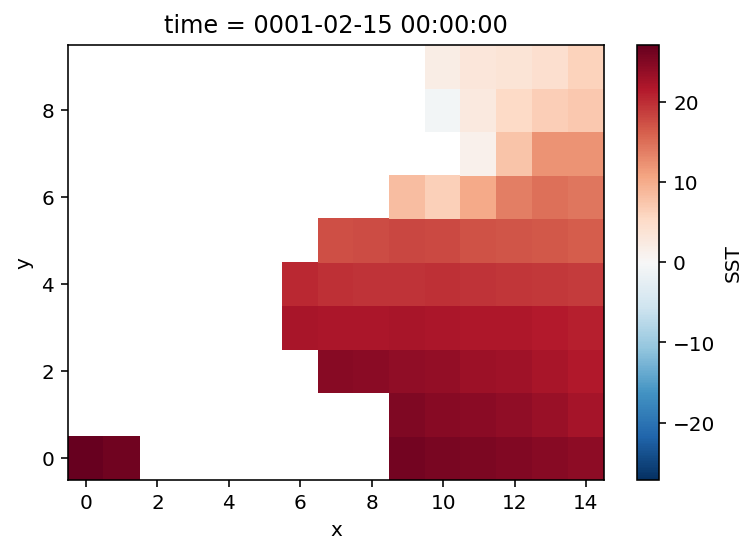

In [63]:
ds_conservative.sel(x=slice(15,30), y=slice(20,30)).isel(time=1).plot()#

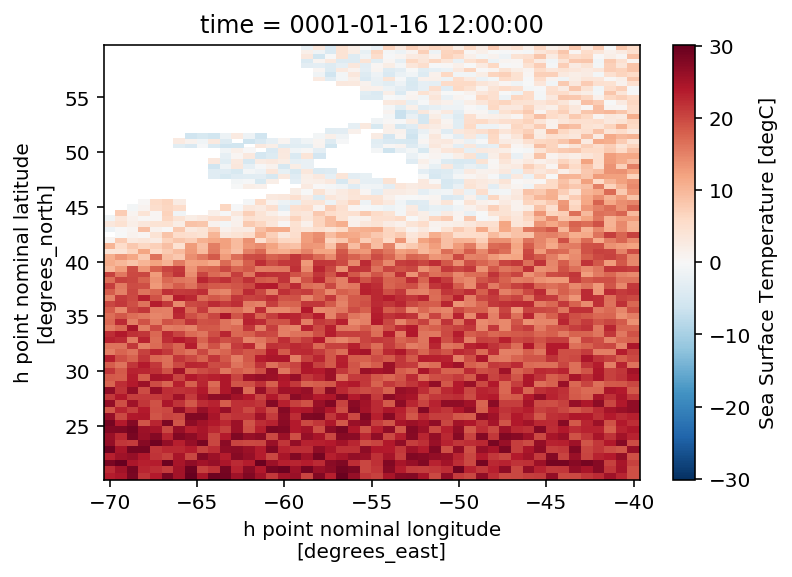

In [75]:
ds_new_noise = ds_new.SST.isel(time=0)
ds_new_noise.data = ds_new_noise.data + (np.random.rand(*ds_new_noise.data.shape)-0.5)*10
ds_new_noise.sel(xh=slice(-70, -40), yh=slice(20, 60)).plot()



# ds_new_noise.sel(x=slice(15,30), y=slice(20,30)).plot()

Not that big of a difference here, because the data is relatively smooth. This however becomes important when data is more noisy.

Lets add some artificial noise to illustrate this.

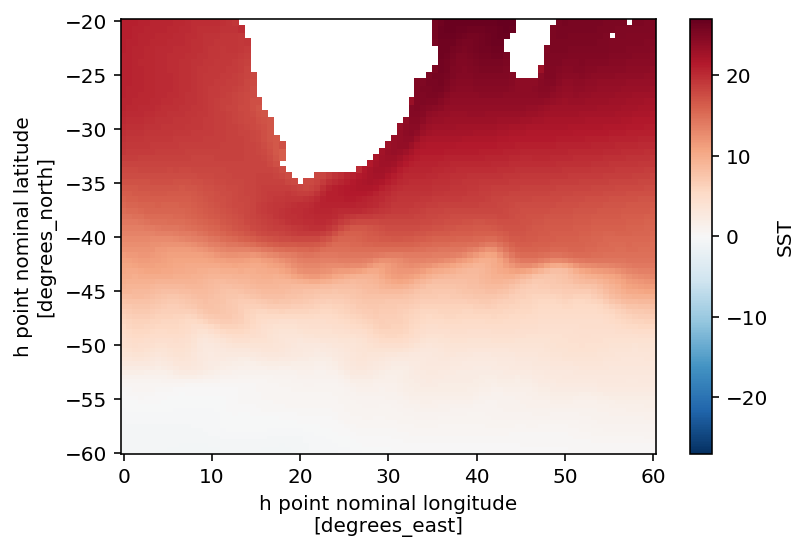

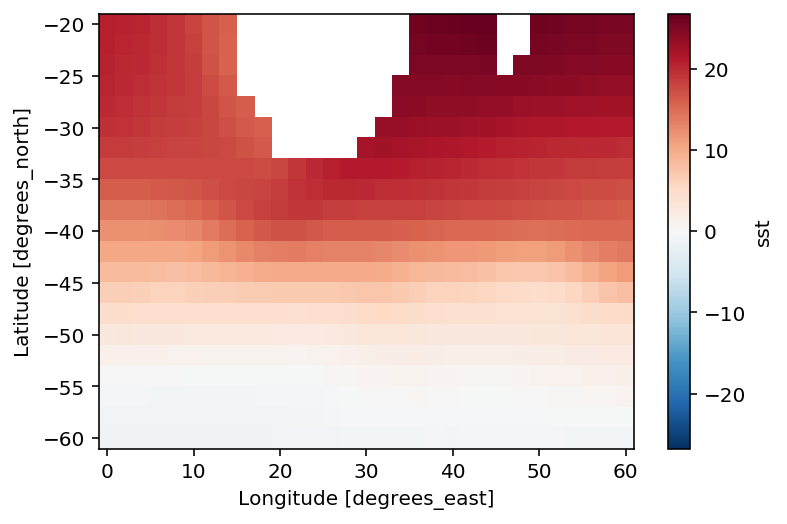

In [48]:
ds_model_region = ds_model.sel(xh=slice(0, 60), yh=slice(-60, -20))
plt.figure()
ds_model_region.sst.isel.plot()


sst_obs_region = sst_obs.sel(lon=slice(0, 60), lat=slice(-20, -60))
plt.figure()
sst_obs_region.plot()

In [ ]:
ds_model.rename({'geolon':'lon', 'geolat':'lat', 'geolonb':'lon_b', 'geolatb':'lat_b'})

In [ ]:
regridder = xe.Regridder(ds_model.rename({'geolon':'lon', 'geolat':'lat', 'geolonb':'lon_b', 'geolatb':'lat_b'}), sst_obs, 'conservative')

In [ ]:
diff = sst_obs - sst_model

In [ ]:
360/len(ds_model.xh)

In [ ]:
360/len(ds_obs.lon)

Things to note:
    The observational dataset is a lot coarser
    
    The model data is not on a regular lat/lon grid. Values around the pole are distorted
    
So how can we compare them?

1. Upsample the lower resolution data

2. Downsample the higher resolution data

We go with 2 for two seperate reasons: It is not trivial to interpolate with only 

In [11]:
import xesmf as xe

In [12]:
ds_out = xr.Dataset({'lat': (['lat'], np.arange(16, 75, 1.0)),
                     'lon': (['lon'], np.arange(200, 330, 1.5)),
                    }
                   )

regridder = xe.Regridder(sst, ds_out, 'bilinear')
regridder.clean_weight_file()
regridder

Create weight file: bilinear_89x180_59x87.nc
Remove file bilinear_89x180_59x87.nc


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_89x180_59x87.nc 
Reuse pre-computed weights? False 
Input grid shape:           (89, 180) 
Output grid shape:          (59, 87) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

In [13]:
%time ds_out = regridder(sst)
ds_out

CPU times: user 5.87 ms, sys: 120 µs, total: 5.99 ms
Wall time: 10.4 ms


<xarray.DataArray 'sst' (time: 1990, lat: 59, lon: 87)>
dask.array<shape=(1990, 59, 87), dtype=float64, chunksize=(12, 59, 87)>
Coordinates:
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2019-10-01
  * lon      (lon) float64 200.0 201.5 203.0 204.5 ... 324.5 326.0 327.5 329.0
  * lat      (lat) float64 16.0 17.0 18.0 19.0 20.0 ... 70.0 71.0 72.0 73.0 74.0
Attributes:
    regrid_method:  bilinear

In [14]:
# for the conservative I need bounds....

In [15]:
# # regrid sst observations on 5*5 deg grid
# ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 5.0)),
#                      'lon': (['lon'], np.arange(0, 360, 5.0)),
#                     }
#                    )

# we can also do this for short
ds_out = xe.util.grid_global(5, 5)

model_regridder = xe.Regridder(sst_model.rename({'geolon':'lon', 'geolat':'lat'}), ds_out, 'bilinear')
model_regridder.clean_weight_file()
obs_regridder = xe.Regridder(sst, ds_out, 'bilinear', periodic=True)
obs_regridder.clean_weight_file()

Create weight file: bilinear_458x540_36x72.nc
Remove file bilinear_458x540_36x72.nc
Create weight file: bilinear_89x180_36x72_peri.nc
Remove file bilinear_89x180_36x72_peri.nc


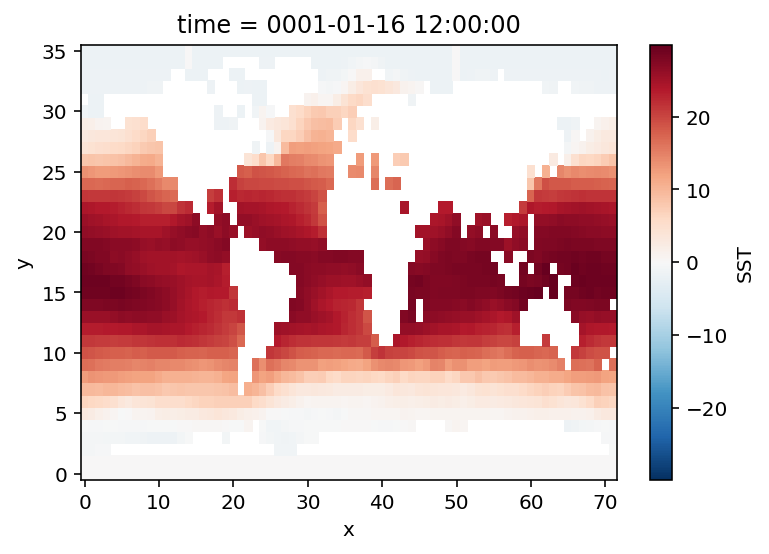

In [16]:
sst_model_5_5 = model_regridder(sst_model)
sst_model_5_5.isel(time=0).plot()

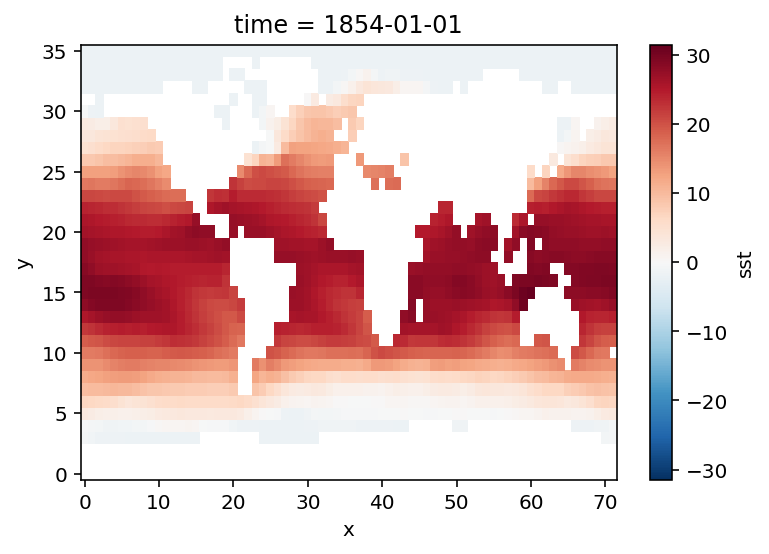

In [17]:
sst_obs_5_5 = obs_regridder(sst)
sst_obs_5_5.isel(time=0).plot()

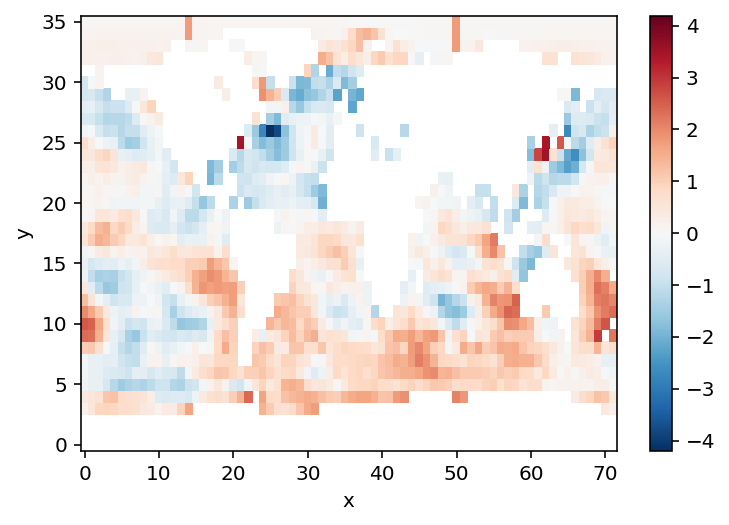

In [18]:
# compare bothd
sst_diff = sst_model_5_5.isel(time=0) - sst_obs_5_5.isel(time=0)
sst_diff.plot()

Thos differences are quite large, but what we are doing here is quite unfair: Comparing a single timestep between model and observations. Lets take an average over 2 years (we do not have a longer record in the model, since this is only an example).

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


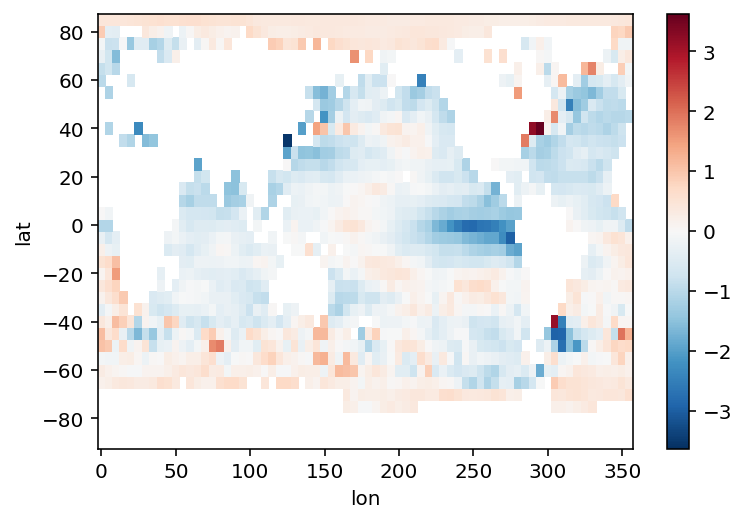

In [53]:
sst_diff = sst_model_5_5.mean('time') - sst_obs_5_5.sel(time=slice('1997', '1998')).mean('time')
sst_diff.plot()

In [54]:
sst_obs_5_5.time

<xarray.DataArray 'time' (time: 1990)>
array(['1854-01-01T00:00:00.000000000', '1854-02-01T00:00:00.000000000',
       '1854-03-01T00:00:00.000000000', ..., '2019-08-01T00:00:00.000000000',
       '2019-09-01T00:00:00.000000000', '2019-10-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2019-10-01
Attributes:
    long_name:        Time
    delta_t:          0000-01-00 00:00:00
    avg_period:       0000-01-00 00:00:00
    prev_avg_period:  0000-00-07 00:00:00
    standard_name:    time
    axis:             T
    actual_range:     [19723. 80261.]
    _ChunkSizes:      1

Now this looks like the mirrored image of the El Niño SST anomaly. The two years in the observations captured one of the strongest El Niño events on the record, and the model probably did not. So lets take a look at some years that hav e a low NINO3.4 index.

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


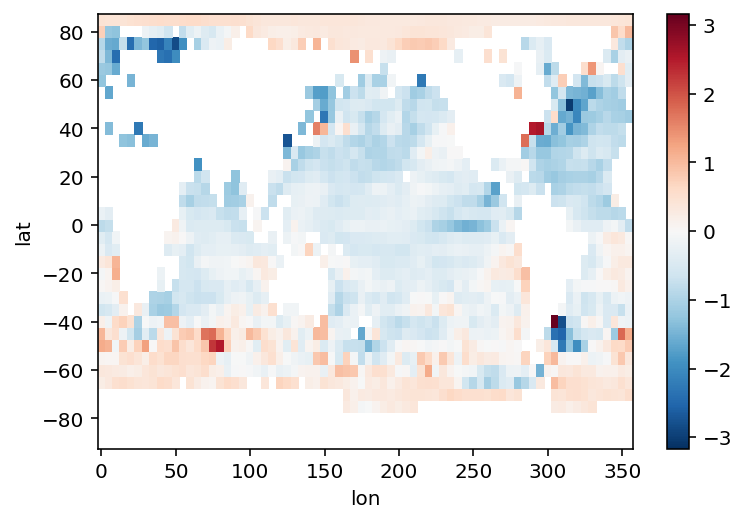

In [55]:
sst_diff = sst_model_5_5.mean('time') - sst_obs_5_5.sel(time=slice('2005', '2006')).mean('time')
sst_diff.plot()

The strong anomaly in the equatorial Pacific has disapeared but we can still see that generally the SST seems to be higher in the observations in the tropics and subtropics, but colder in the Southern Ocean and Arctiv

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


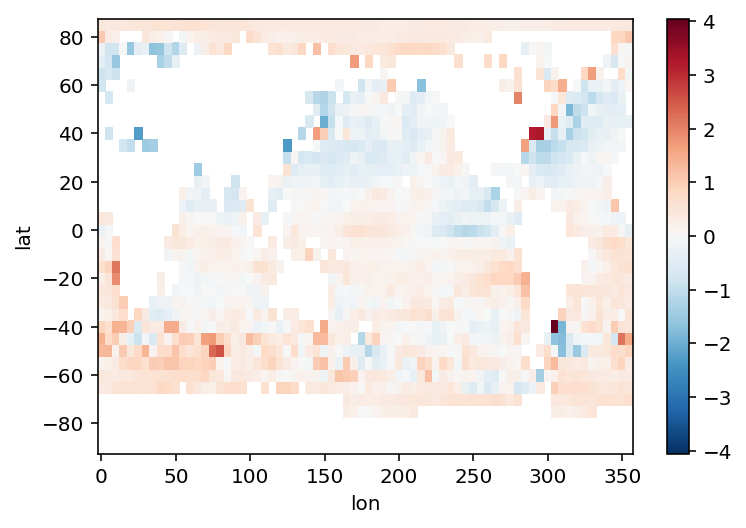

In [56]:
sst_diff = sst_model_5_5.mean('time') - sst_obs_5_5.mean('time')
sst_diff.plot(vmax=3)

In [12]:
# regrid both data onto even coarser grid

In [13]:
sst.isel(time=0)

<xarray.DataArray 'sst' (lat: 89, lon: 180)>
dask.array<getitem, shape=(89, 180), dtype=float32, chunksize=(89, 180), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
    time     datetime64[ns] 1997-01-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]
    _ChunkSizes:   [  1  89 180]

In [ ]:
# construct a regridder for the model data
sst_model_renamed = sst_model.rename({'geolon':'lon', 'geolat':'lat'})

regridder = xe.Regridder(sst_model_renamed.isel(time=0), sst.isel(time=0), 'bilinear')
regridder.clean_weight_file()
regridder